# Libraries and Data Information

In [1]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt

from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import r2_score

import tensorflow as tf
from keras.layers import Dense,Dropout,SimpleRNN,LSTM
from keras.models import Sequential

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))
    
import warnings
warnings.filterwarnings("ignore") 

### PJM Hourly Energy Consumption Data
* PJM Interconnection LLC (PJM) is a regional transmission organization (RTO) in the United States. It is part of the Eastern Interconnection grid operating an electric transmission system serving all or parts of Delaware, Illinois, Indiana, Kentucky, Maryland, Michigan, New Jersey, North Carolina, Ohio, Pennsylvania, Tennessee, Virginia, West Virginia, and the District of Columbia.

* The hourly power consumption data comes from PJM's website and are in megawatts (MW).

* The regions have changed over the years so data may only appear for certain dates per region.

* There are 13 regions. In this notebook we will continue using data from Dominion Virginia Power (DOM)

# Read and Check Data

In [2]:
# DOM_MW --->> Dominion Virginia Power (DOM) - Megawatt Energy Consumption

df = pd.read_csv("DOM_hourly.csv")
df.head()

,Datetime,DOM_MW
0,2005-12-31 01:00:00,9389.0
1,2005-12-31 02:00:00,9070.0
2,2005-12-31 03:00:00,9001.0
3,2005-12-31 04:00:00,9042.0
4,2005-12-31 05:00:00,9132.0


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 116189 entries, 0 to 116188
Data columns (total 2 columns):
 #   Column    Non-Null Count   Dtype  
---  ------    --------------   -----  
 0   Datetime  116189 non-null  object 
 1   DOM_MW    116189 non-null  float64
dtypes: float64(1), object(1)
memory usage: 1.8+ MB


In [4]:
# We must convert the Datetime column to Datetime format
df['Datetime'] = pd.to_datetime(df['Datetime'])

# We index the Datetime column after transformation
df.set_index('Datetime', inplace=True)
df.head()

,DOM_MW
Datetime,
2005-12-31 01:00:00,9389.0
2005-12-31 02:00:00,9070.0
2005-12-31 03:00:00,9001.0
2005-12-31 04:00:00,9042.0
2005-12-31 05:00:00,9132.0


In [5]:
# checking missing data
df.isna().sum()

DOM_MW    0
dtype: int64

In [6]:
# Let's look at the years in the data set
years = df.index.year.unique()
years

Index([2005, 2006, 2007, 2008, 2009, 2010, 2011, 2012, 2013, 2014, 2015, 2016,
       2017, 2018],
      dtype='int32', name='Datetime')

In [7]:
# Let's see the average energy consumed per year 
df_yearly_avg = df['DOM_MW'].resample('Y').mean()
df_yearly_avg.to_frame()

,DOM_MW
Datetime,
2005-12-31,10833.524668
2006-12-31,10457.146951
2007-12-31,10991.015871
2008-12-31,10786.751765
2009-12-31,10696.930235
2010-12-31,11280.065548
2011-12-31,10865.571021
2012-12-31,10614.735368
2013-12-31,10904.946677


* As can be seen, there are no missing values in our data 
* Now let's observe our data set on the graph

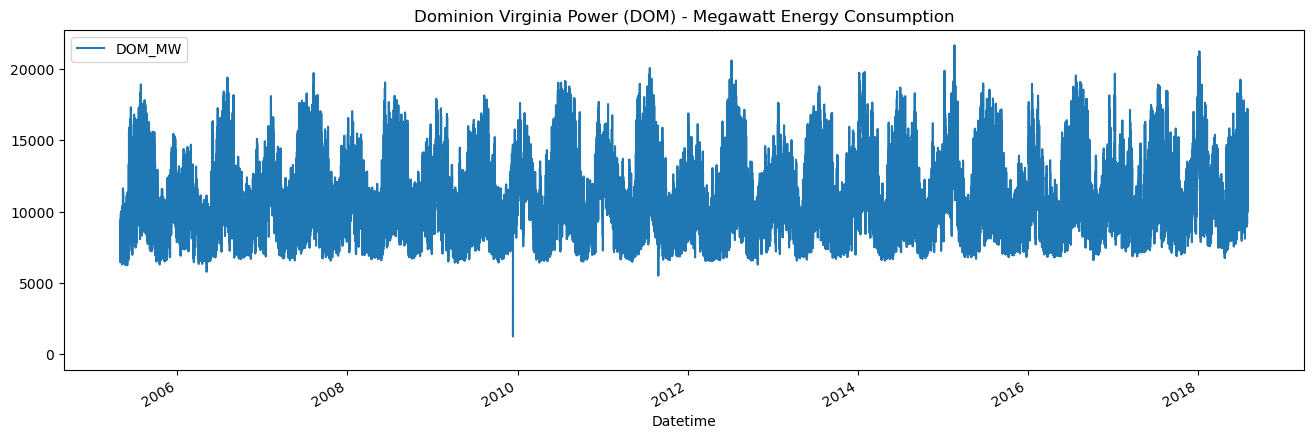

In [8]:
df.plot(figsize=(16,5),legend=True)
plt.axhspan(0, 1, facecolor='gray', alpha=0.3)

plt.title('Dominion Virginia Power (DOM) - Megawatt Energy Consumption')

plt.show()

# Normalization Process

In [9]:
def normalize_data(df):
    scaler = MinMaxScaler()
    normalized_data = scaler.fit_transform(df['DOM_MW'].values.reshape(-1,1))
    df['DOM_MW'] = normalized_data
    return df, scaler

df_norm, scaler = normalize_data(df)
df_norm.shape

(116189, 1)

In [10]:
df_norm

,DOM_MW
Datetime,
2005-12-31 01:00:00,0.398863
2005-12-31 02:00:00,0.383224
2005-12-31 03:00:00,0.379841
2005-12-31 04:00:00,0.381851
2005-12-31 05:00:00,0.386263
...,...
2018-01-01 20:00:00,0.841504
2018-01-01 21:00:00,0.848809
2018-01-01 22:00:00,0.836062


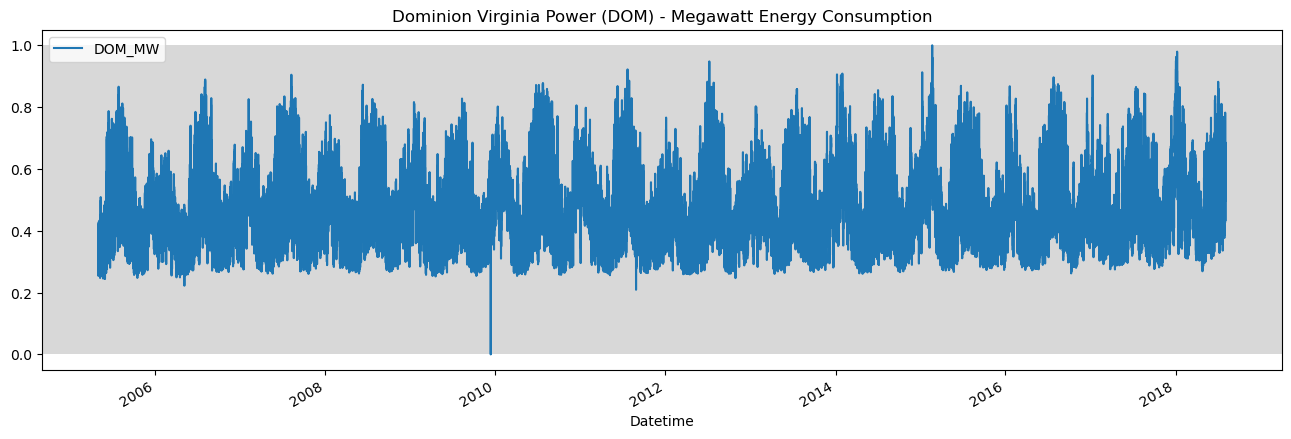

In [11]:
# Now after normalization we can observe that the data range on y-axis is 0.0 - 1.0

df.plot(figsize=(16,5),legend=True)
plt.axhspan(0, 1, facecolor='gray', alpha=0.3)

plt.title('Dominion Virginia Power (DOM) - Megawatt Energy Consumption')

plt.show()

### Let's observe train and test data on the graph

In [12]:
# 2017-02-13 after this date we will choose the test set
split_date = '2017-02-13'

DOM_train = df_norm.loc[df_norm.index <= split_date].copy()
DOM_test = df_norm.loc[df_norm.index > split_date].copy()

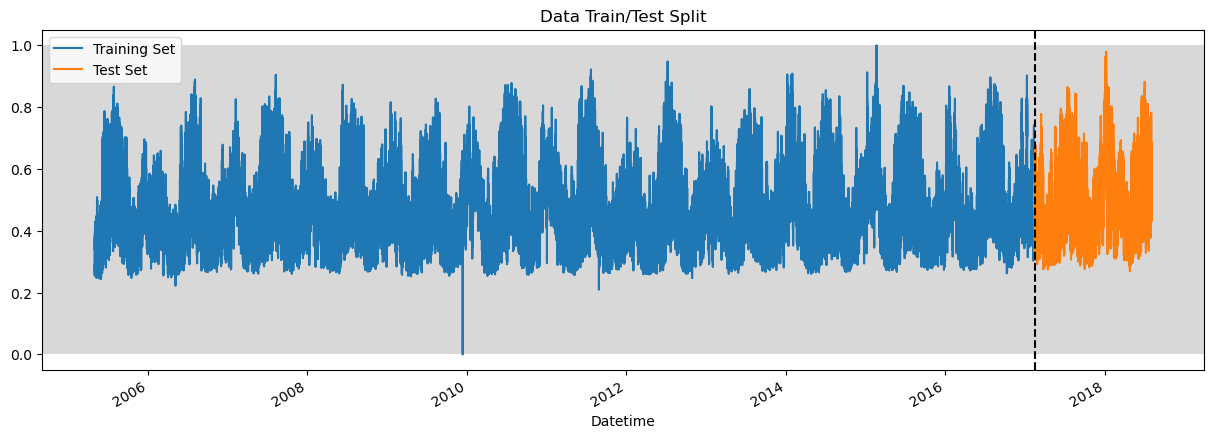

In [13]:
fig, ax = plt.subplots(figsize=(15, 5))
DOM_train.plot(ax=ax, label='Training Set', title='Data Train/Test Split')
DOM_test.plot(ax=ax, label='Test Set')
ax.axvline('2017-02-13', color='black', ls='--')
ax.legend(['Training Set', 'Test Set'])
plt.axhspan(0, 1, facecolor='gray', alpha=0.3)
plt.show()

# Prepare Data for Training the RNN & LSTM

* With the following function block, let's set our data set as training and test data set in a model appropriate way

In [14]:
def load_data(data, seq_len):
    X_train = []
    y_train = []
    
    for i in range(seq_len, len(data)):
        X_train.append(data.iloc[i-seq_len : i, 0])
        y_train.append(data.iloc[i, 0])
    
    # last 6189 days are going to be used in test
    X_test = X_train[110000:]             
    y_test = y_train[110000:]
    
    # first 110000 days are going to be used in training
    X_train = X_train[:110000]           
    y_train = y_train[:110000]
    
    # convert to numpy array
    X_train = np.array(X_train)
    y_train = np.array(y_train)
    
    X_test = np.array(X_test)
    y_test = np.array(y_test)
    
    # reshape data to input into RNN&LSTM models
    X_train = np.reshape(X_train, (110000, seq_len, 1))
    
    X_test = np.reshape(X_test, (X_test.shape[0], seq_len, 1))
    
    return [X_train, y_train, X_test, y_test]

* **The seq_len** parameter determines how far back the model will look at historical data, helping the model to capture time dependencies in a memory-aware way.
* We should note that if "seq_len" is too large, the model can become complex and prone to overlearning.
* We can specify separate seq_len values for RNN and LSTM 

In [15]:
seq_len = 10

# Let's create train, test data
X_train, y_train, X_test, y_test = load_data(df, seq_len)

print('X_train.shape = ',X_train.shape)
print('y_train.shape = ', y_train.shape)
print('X_test.shape = ', X_test.shape)
print('y_test.shape = ',y_test.shape)

X_train.shape =  (110000, 10, 1)
y_train.shape =  (110000,)
X_test.shape =  (6179, 10, 1)
y_test.shape =  (6179,)


# Build a RNN model

In [16]:
rnn_model = Sequential()

rnn_model.add(SimpleRNN(40,activation="tanh",return_sequences=True, input_shape=(X_train.shape[1],1)))
rnn_model.add(Dropout(0.15))

rnn_model.add(SimpleRNN(40,activation="tanh",return_sequences=True))
rnn_model.add(Dropout(0.15))

rnn_model.add(SimpleRNN(40,activation="tanh",return_sequences=False))
rnn_model.add(Dropout(0.15))

rnn_model.add(Dense(1))

rnn_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 simple_rnn (SimpleRNN)      (None, 10, 40)            1680      
                                                                 
 dropout (Dropout)           (None, 10, 40)            0         
                                                                 
 simple_rnn_1 (SimpleRNN)    (None, 10, 40)            3240      
                                                                 
 dropout_1 (Dropout)         (None, 10, 40)            0         
                                                                 
 simple_rnn_2 (SimpleRNN)    (None, 40)                3240      
                                                                 
 dropout_2 (Dropout)         (None, 40)                0         
                                                                 
 dense (Dense)               (None, 1)                 4

In [17]:
rnn_model.compile(optimizer="adam",loss="MSE")
rnn_model.fit(X_train, y_train, epochs=10, batch_size=1000)

Epoch 1/10
110/110 [==============================] - 21s 79ms/step - loss: 0.1051
Epoch 2/10
110/110 [==============================] - 9s 78ms/step - loss: 0.0258
Epoch 3/10
110/110 [==============================] - 9s 80ms/step - loss: 0.0162
Epoch 4/10
110/110 [==============================] - 9s 80ms/step - loss: 0.0114
Epoch 5/10
110/110 [==============================] - 9s 81ms/step - loss: 0.0088
Epoch 6/10
110/110 [==============================] - 9s 80ms/step - loss: 0.0070
Epoch 7/10
110/110 [==============================] - 9s 80ms/step - loss: 0.0059
Epoch 8/10
110/110 [==============================] - 9s 79ms/step - loss: 0.0050
Epoch 9/10
110/110 [==============================] - 9s 78ms/step - loss: 0.0043
Epoch 10/10
110/110 [==============================] - 9s 78ms/step - loss: 0.0038


In [18]:
rnn_predictions = rnn_model.predict(X_test)

rnn_score = r2_score(y_test,rnn_predictions)
print("R2 Score of RNN model = ",rnn_score)

194/194 [==============================] - 4s 7ms/step
R2 Score of RNN model =  0.9286942500299049


In [19]:
# Reverse transform scaler to convert to real values
y_test_inverse = scaler.inverse_transform(y_test.reshape(-1, 1))
rnn_predictions_inverse = scaler.inverse_transform(rnn_predictions)

# Get values after inverse transformation
y_test_inverse = y_test_inverse.flatten()
rnn_predictions_inverse = rnn_predictions_inverse.flatten()

In [20]:
last_6169_index_dates = df.index[-6169:]

# Now let's see our actual y and predicted y values as dataframes 
results_RNN = pd.DataFrame({"Date":last_6169_index_dates, 'Actual': y_test_inverse, 'Predicted': rnn_predictions_inverse})
results_RNN

ValueError: All arrays must be of the same length

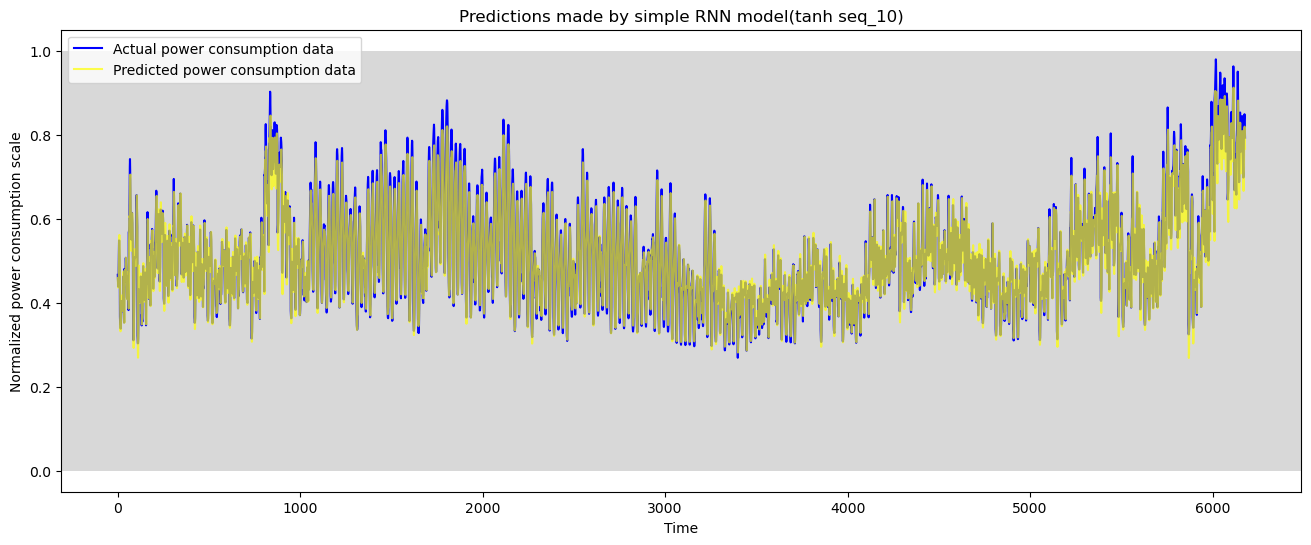

In [27]:
plt.figure(figsize=(16,6))
plt.plot(y_test, color='blue',label='Actual power consumption data')
plt.plot(rnn_predictions, alpha=0.7, color='yellow', label='Predicted power consumption data')
plt.axhspan(0, 1, facecolor='gray', alpha=0.3)
plt.title("Predictions made by simple RNN model(tanh seq_10)")
plt.xlabel('Time')
plt.ylabel('Normalized power consumption scale')
plt.legend()
plt.show()

# Build an LSTM model

In [22]:
lstm_model = Sequential()

lstm_model.add(LSTM(40,activation="tanh",return_sequences=True, input_shape=(X_train.shape[1],1)))
lstm_model.add(Dropout(0.15))

lstm_model.add(LSTM(40,activation="tanh",return_sequences=True))
lstm_model.add(Dropout(0.15))

lstm_model.add(LSTM(40,activation="tanh",return_sequences=False))
lstm_model.add(Dropout(0.15))

lstm_model.add(Dense(1))

lstm_model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 10, 40)            6720      
                                                                 
 dropout_3 (Dropout)         (None, 10, 40)            0         
                                                                 
 lstm_1 (LSTM)               (None, 10, 40)            12960     
                                                                 
 dropout_4 (Dropout)         (None, 10, 40)            0         
                                                                 
 lstm_2 (LSTM)               (None, 40)                12960     
                                                                 
 dropout_5 (Dropout)         (None, 40)                0         
                                                                 
 dense_1 (Dense)             (None, 1)                

In [23]:
lstm_model.compile(optimizer="adam",loss="MSE")
lstm_model.fit(X_train, y_train, epochs=10, batch_size=1000)

Epoch 1/10
110/110 [==============================] - 16s 96ms/step - loss: 0.0223
Epoch 2/10
110/110 [==============================] - 10s 92ms/step - loss: 0.0114
Epoch 3/10
110/110 [==============================] - 11s 100ms/step - loss: 0.0083
Epoch 4/10
110/110 [==============================] - 14s 129ms/step - loss: 0.0058
Epoch 5/10
110/110 [==============================] - 15s 141ms/step - loss: 0.0045
Epoch 6/10
110/110 [==============================] - 15s 132ms/step - loss: 0.0034
Epoch 7/10
110/110 [==============================] - 14s 123ms/step - loss: 0.0029
Epoch 8/10
110/110 [==============================] - 13s 118ms/step - loss: 0.0025
Epoch 9/10
110/110 [==============================] - 13s 117ms/step - loss: 0.0022
Epoch 10/10
110/110 [==============================] - 13s 120ms/step - loss: 0.0020


In [24]:
lstm_predictions = lstm_model.predict(X_test)

lstm_score = r2_score(y_test, lstm_predictions)
print("R^2 Score of LSTM model = ",lstm_score)

194/194 [==============================] - 3s 6ms/step
R^2 Score of LSTM model =  0.936643012905205


In [25]:
# Reverse transform scaler to convert to real values
y_test_inverse = scaler.inverse_transform(y_test.reshape(-1, 1))
lstm_predictions_inverse = scaler.inverse_transform(lstm_predictions)

# Get values after inverse transformation
y_test_inverse = y_test_inverse.flatten()
lstm_predictions_inverse = lstm_predictions_inverse.flatten()

In [26]:
# Now let's see our actual y and predicted y values as dataframes 
results_LSTM = pd.DataFrame({"Date":last_6169_index_dates, 'Actual': y_test_inverse, 'Predicted': lstm_predictions_inverse})
results_LSTM

ValueError: All arrays must be of the same length

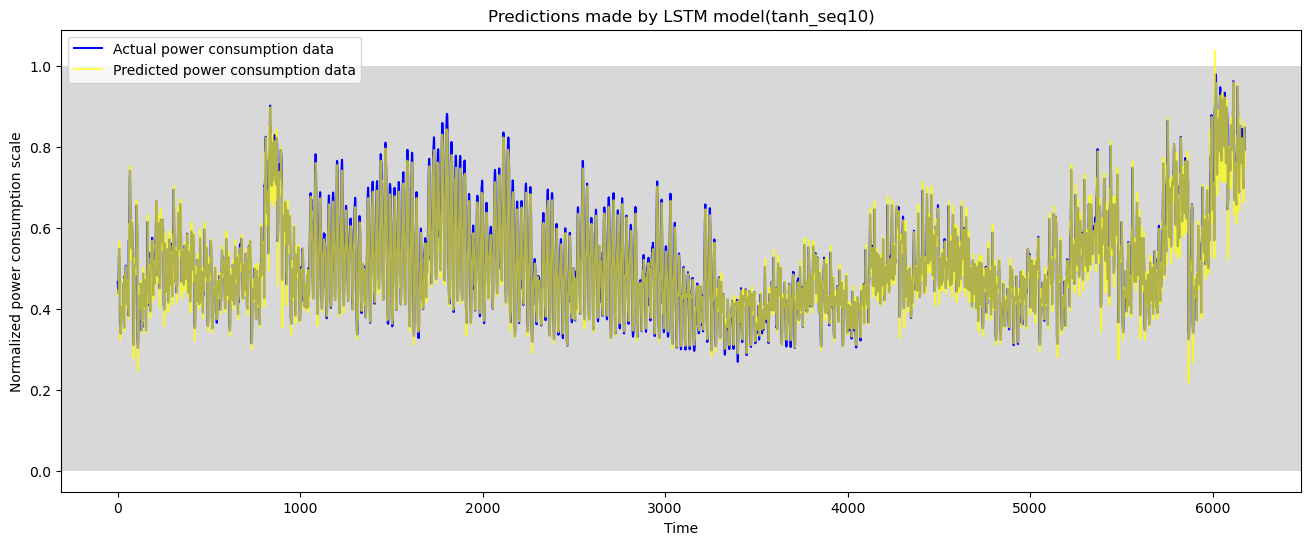

In [29]:
plt.figure(figsize=(16,6))
plt.plot(y_test, color='blue',label='Actual power consumption data')
plt.plot(lstm_predictions, alpha=0.7, color='yellow', label='Predicted power consumption data')
plt.axhspan(0, 1, facecolor='gray', alpha=0.3)
plt.title("Predictions made by LSTM model(tanh_seq10)")
plt.xlabel('Time')
plt.ylabel('Normalized power consumption scale')
plt.legend()
plt.show()

# Compare Predictions

* For both models, we see that the predicted values are close to the actual values, which means that the models perform well in predicting the sequence.

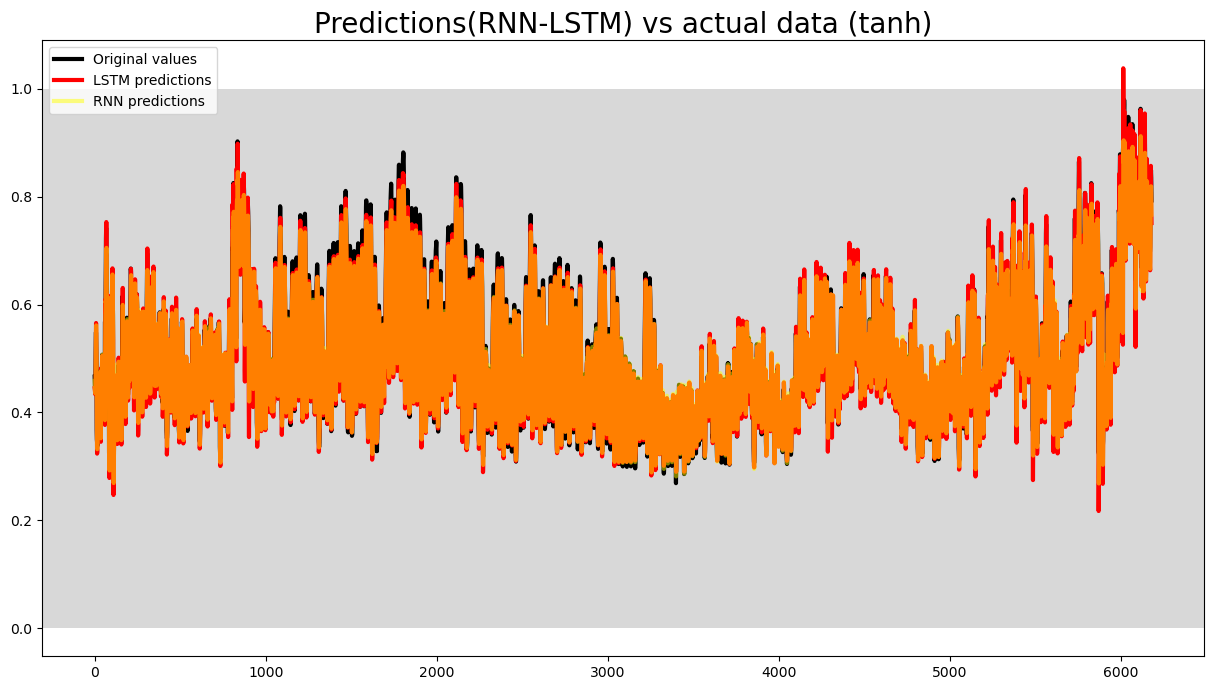

In [30]:
plt.figure(figsize=(15,8))

plt.plot(y_test, c="black", linewidth=3, label="Original values")
plt.plot(lstm_predictions, c="red", linewidth=3, label="LSTM predictions")
plt.plot(rnn_predictions, alpha=0.5, c="yellow", linewidth=3, label="RNN predictions")
plt.axhspan(0, 1, facecolor='gray', alpha=0.3)  
plt.legend()
plt.title("Predictions(RNN-LSTM) vs actual data (tanh)", fontsize=20)
plt.show()

In [ ]:
# İki DataFrame'i 'Date' sütunu üzerinden birleştir
results_combined = pd.merge(results_RNN[['Date', 'Actual', 'Predicted']], results_LSTM[['Date', 'Predicted']], on='Date')

# Sütun isimlerini yeniden adlandırma
results_combined.columns = ['Date', 'Actual', 'RNN Prediction', 'LSTM Prediction']


results_combined